In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/saved_model.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/keras_metadata.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/assets/vocab.txt
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/variables/variables.index
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/variables/variables.data-00000-of-00001
/kaggle/input/gpt2/keras/gpt2_base_en/1/config.json
/kaggle/input/gpt2/keras/gpt2_base_en/1/tokenizer.json
/kaggle/input/gpt2/keras/gpt2_base_en/1/metadata.json
/kaggle/input/gpt2/keras/gpt2_base_en/1/model.weights.h5
/kaggle/input/gpt2/keras/gpt2_base_en/1/assets/tokenizer/merges.txt
/kaggle/input/gpt2/keras/gpt2_base_en/1/assets/tokenizer/vocabulary.json
/kaggle/input/stopwords/stopwords/norwegian
/kaggle/input/stopwords/stopwords/english
/kaggle/input/stopwords/stopwords/README
/kaggle/input/stopwords/stopwords/french
/kaggle/input/stopwords/stopwords/kaz

# analyse de sentiments Twitter avec les données 1,6m tweets by twitter Api
Le traitement automatique de la langue est un domaine multidisciplinaire impliquant la
linguistique, l'informatique et l'intelligence artificielle. Il vise à créer des outils de traitement de
la langue naturelle pour diverses applications. Parmi ces applications, nous pouvons citer celles
qui relèvent du traitement des réseaux sociaux. Les sites de médias sociaux, tels que Twitter,
sont une source riche de nombreux types d'informations, notamment en matière de santé.
Ce projet consiste à développer des modèles de classification des sentiments (positive, negative
ou neutre) sur les réseaux sociaux avec trois architectures différentes **(LSTM, BERT, et GPT)**,
et à évaluer le meilleur d’entre eux.

In [12]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

from nltk.stem import SnowballStemmer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.13.0


In [13]:
import nltk
from nltk.corpus import stopwords

In [14]:
df=pd.read_csv('/kaggle/input/stopwords/stopwords/english')

In [15]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=DATASET_COLUMNS)

In [16]:
df.head(10)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [17]:
df= df[['sentiment','text']]

In [18]:
df.head(20)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [19]:
print("Dataset size :" ,len(df))

Dataset size : 1600000


In [20]:
lab_to_sentiment = {0:"Negative",2:"Neutral", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()
#La ligne df.sentiment = df.sentiment.apply(lambda x: label_decoder(x)) applique la fonction label_decoder à chaque élément de la colonne "sentiment" du DataFrame df. Cela remplace essentiellement les valeurs numériques de la colonne "sentiment" par les étiquettes textuelles correspondantes.

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Distribution Des Sentiment')

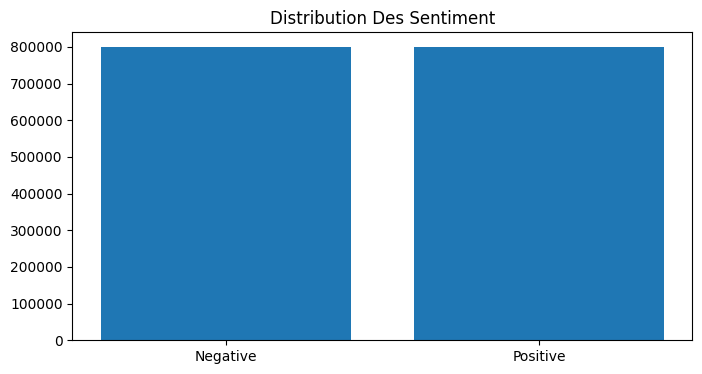

In [21]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Distribution Des Sentiment")

Phase de PreProcessing - Cleaning Data
# Stemming/ Lematization
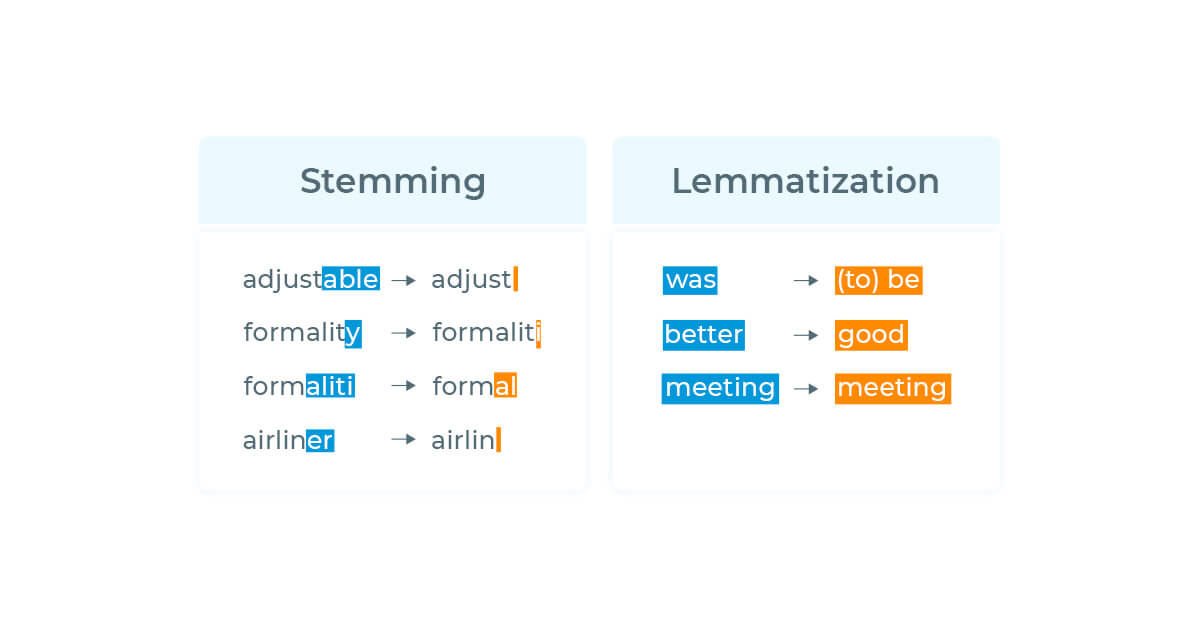
# Stopwords
# LinksandTags

In [22]:
# Importation des mots vides (stop words) de la langue anglaise à partir du module nltk
stop_words = stopwords.words('english')

# Initialisation d'un stemmer (racinisateur) pour la langue anglaise à partir du module nltk
stemmer = SnowballStemmer('english')

# Expression régulière utilisée pour le nettoyage du texte :
# - Les termes qui commencent par "@" sont supprimés (peut être utilisé pour éliminer les mentions dans les médias sociaux).
# - Les liens URL commençant par "https" ou "http" sont supprimés.
# - Tous les caractères qui ne sont pas des lettres (A-Z, a-z) ou des chiffres (0-9) sont supprimés.
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [23]:
# Définition de la fonction preprocess avec deux paramètres : text (le texte à prétraiter) et stem (un indicateur pour activer ou désactiver le stemming)
def preprocess(text, stem=False):
  
  # Utilisation de l'expression régulière définie précédemment pour nettoyer le texte :
  # - Convertit le texte en minuscules.
  # - Supprime les termes commençant par "@".
  # - Supprime les liens URL.
  # - Supprime tous les caractères qui ne sont pas des lettres (A-Z, a-z) ou des chiffres (0-9).
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  
  # Initialisation d'une liste vide pour stocker les tokens après le prétraitement
  tokens = []

  # Boucle sur chaque token du texte après séparation par l'espace
  for token in text.split():
    # Vérification si le token n'est pas dans la liste des mots vides (stop words)
    if token not in stop_words:
      # Si l'option stem est activée, le stemming est appliqué au token
      if stem:
        tokens.append(stemmer.stem(token))
      # Sinon, le token est ajouté tel quel à la liste
      else:
        tokens.append(token)

  # La fonction renvoie une chaîne de caractères résultant de la jointure des tokens après le prétraitement
  return " ".join(tokens)


In [24]:
df.text = df.text.apply(lambda x: preprocess(x))


In [25]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
1504180,Positive,good nigth ddlovato hope great day ur team tea...
1302468,Positive,monkey baby called wayne
75819,Negative,good point riding profuse oil leak
1342746,Positive,gulf shores visiting family everyone
82735,Negative,7th ladder sinking lower lower every week boys...
1436373,Positive,old friends new friends plus people know hahahaha
517570,Negative,take good thing
1487289,Positive,love ashley new songs go ashley xd
1118755,Positive,uncharted 2 beta gamenight anyone
60477,Negative,feeling neglected today


In [26]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))
train_data.head()


Train Data size: 1280000
Test Data size 320000


,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...


In [27]:
test_data.head()

,sentiment,text
709290,Negative,feelin lately reason
654075,Negative,ju clare elly zoe leave marbella
728623,Negative,wish couldve seen miley nick sing 2night
697650,Negative,work today 1 hour 6 go
1244425,Positive,started catch house viewing kind odd watched b...


# Tokenization
La tokenization a pour but de diviser un texte en unités linguistiques de base, appelées "tokens". Ces tokens peuvent être des mots, des phrases, des sous-mots, ou d'autres unités, selon le niveau de granularité souhaité. La tokenization est une étape essentielle dans le traitement du langage naturel et facilite l'analyse du texte en permettant de manipuler et de comprendre plus facilement les éléments individuels qui le composent. Elle constitue souvent la première étape du prétraitement de texte avant des tâches telles que l'analyse de sentiment, la classification de texte, ou la génération de texte.
Tokenization:

**Définition** : La tokenization est le processus de décomposition d'une séquence de caractères, généralement un morceau de texte, en unités individuelles appelées tokens.

**Objectif** : L'objectif principal de la tokenization est de segmenter le texte en unités significatives, souvent des mots, tout en éliminant certains caractères tels que la ponctuation.

**Résultat** : La tokenization aboutit à une collection de tokens, qui sont les éléments de base pour des analyses ultérieures.

Tokenization en Traitement du Langage Naturel (NLP) :

**Tâche **: Dans le contexte du TALN, la tokenization implique la création de tokens pour chaque mot dans un corpus de données donné.

**Mapping vers un Index** : Chaque token est généralement associé à un index à l'aide d'un dictionnaire ou d'une structure de données similaire.

**Index des Mots** : La structure de données, souvent appelée word_index, contient l'index de chaque mot unique dans le corpus.

Taille du Vocabulaire :

**Définition** : Le terme "vocab_size" représente le nombre total de mots ou de tokens uniques présents dans le corpus de données.

**Signification** : Il donne une indication de la richesse ou de la diversité du vocabulaire au sein du jeu de données donné.

In [28]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [29]:
# Importation de la fonction pad_sequences depuis le module keras.preprocessing.sequence
from keras.preprocessing.sequence import pad_sequences

# Application du padding aux données d'entraînement (train_data.text)
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen=MAX_SEQUENCE_LENGTH)

# Application du padding aux données de test (test_data.text)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen=MAX_SEQUENCE_LENGTH)

# Affichage des dimensions des données d'entraînement et de test après le padding
print("Training X Shape:", x_train.shape)
print("Testing X Shape:", x_test.shape)


Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [30]:
labels = train_data.sentiment.unique().tolist()


In [31]:
# Importation de la classe LabelEncoder depuis le module scikit-learn
encoder = LabelEncoder()

# Entraînement de l'encodeur sur les étiquettes de sentiments des données d'entraînement
encoder.fit(train_data.sentiment.to_list())

# Transformation des étiquettes de sentiments en données encodées pour les données d'entraînement et de test
y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

# Modification de la forme des données encodées pour s'assurer qu'elles sont compatibles avec le modèle
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Affichage des dimensions des données encodées
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [32]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 30)
y_train (1280000, 1)

x_test (320000, 30)
y_test (320000, 1)


In [33]:
y_train[:10]

array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

# Embedding layer

In [34]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

In [35]:
EMBEDDING_DIM = 300  

# Create the Sequential model
model = Sequential()

# Add the Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
# The input_dim is the size of the vocabulary (number of unique words), 
# output_dim is the size of the dense embedding, and input_length is the length of the input sequences.

# Model Training - LSTM

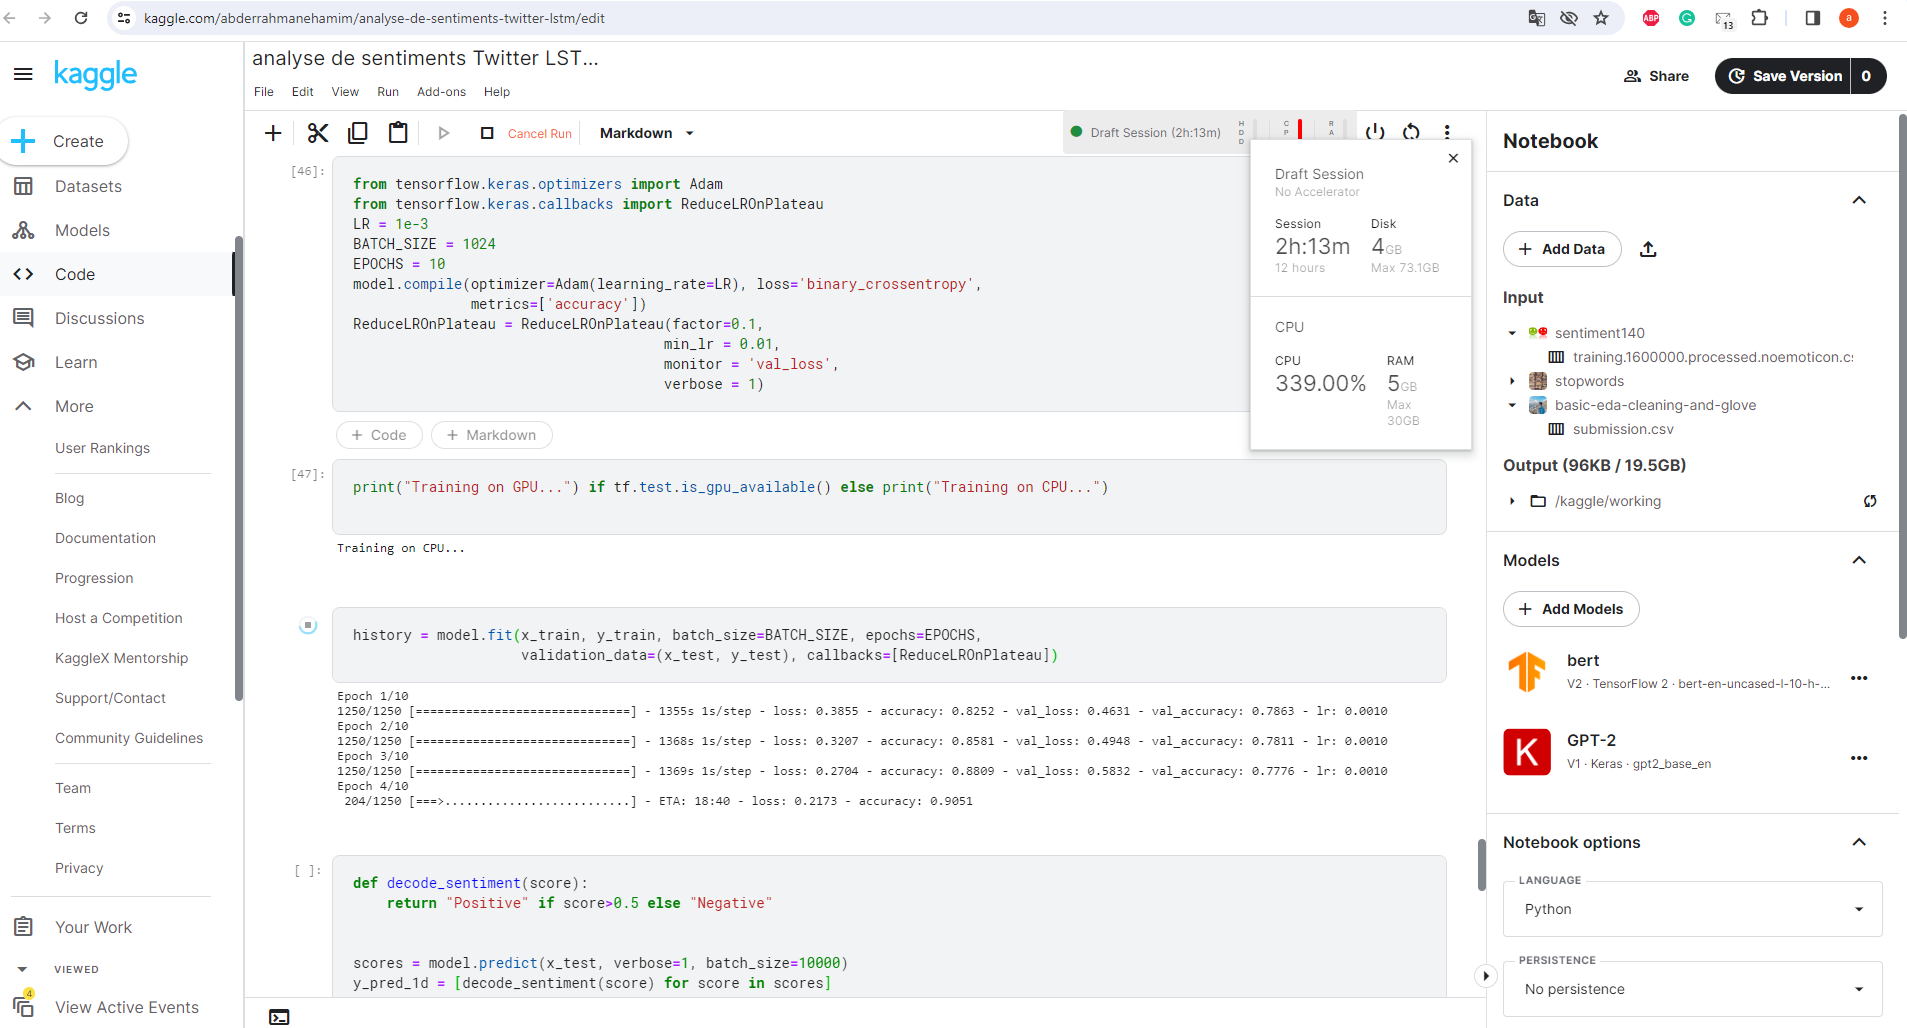

In [39]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model

In [40]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = model(sequence_input)  # Use the defined model here
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)  # Update the model to use the defined layers


In [56]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 3
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [47]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")


Training on CPU...


In [49]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 1355s 1s/step - loss: 0.3855 - accuracy: 0.8252 - val_loss: 0.4631 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 1368s 1s/step - loss: 0.3207 - accuracy: 0.8581 - val_loss: 0.4948 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 1369s 1s/step - loss: 0.2704 - accuracy: 0.8809 - val_loss: 0.5832 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 1377s 1s/step - loss: 0.2356 - accuracy: 0.8965 - val_loss: 0.6524 - val_accuracy: 0.7758 - lr: 0.0010
Epoch 5/10
 677/1250 [===============>..............] - ETA: 10:19 - loss: 0.2050 - accuracy: 0.9101

KeyboardInterrupt: 

In [50]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 27s 832ms/step


In [57]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

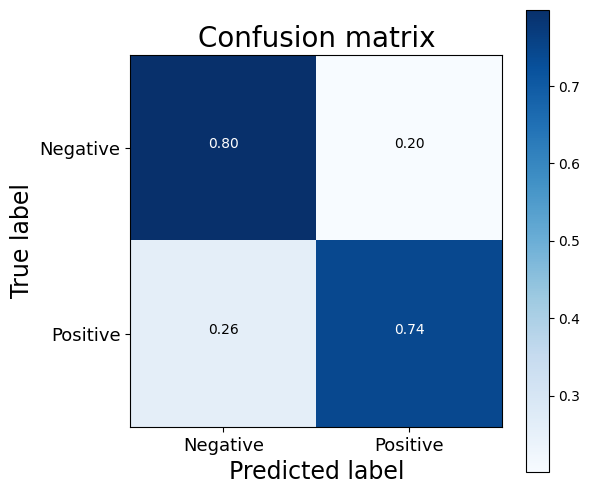

In [58]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [59]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.76      0.80      0.78    160542
    Positive       0.78      0.74      0.76    159458

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



# BERT

**you can see the new notebook called "analyse de sentiments Twitter Bert" I couldn't risk losing all of my work and i devided the dataset in my next model of bert  because i spent to much time waiting for it in Lstm to be trained**

In [91]:
!pip install transformers --upgrade


In [93]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix



In [94]:
import tensorflow as tf
import tensorflow_hub as hub




In [95]:
import os

model_name = 'bert-base-uncased'

# Check if a directory with the model name exists
if os.path.exists(model_name) and os.path.isdir(model_name):
    print(f"A directory with the name '{model_name}' already exists.")
else:
    print(f"No directory found with the name '{model_name}'.")


No directory found with the name 'bert-base-uncased'.


In [98]:
from transformers import BertTokenizer

model_name = 'bert-base-uncased'
local_model_path = '/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2'

# Load BERT tokenizer from the local path
tokenizer = BertTokenizer.from_pretrained('bert-en-uncased', do_lower_case=True)


OSError: Can't load tokenizer for 'bert-en-uncased'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'bert-en-uncased' is the correct path to a directory containing all relevant files for a BertTokenizer tokenizer.

In [77]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['sentiment'])
test_labels = label_encoder.transform(test_data['sentiment'])

In [78]:
# Tokenize and encode the training data
train_encodings = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')


TypeError: 'Tokenizer' object is not callable

In [79]:
# Tokenize and encode the testing data
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

TypeError: 'Tokenizer' object is not callable

In [80]:
# Build the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like bert-base-uncased is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [82]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [83]:
# Train the model
history = model.fit(
    x=train_encodings,
    y=train_labels,
    validation_data=(test_encodings, test_labels),
    epochs=3,
    batch_size=32
)

NameError: name 'train_encodings' is not defined

In [84]:
# Evaluate the model
predictions = model.predict(test_encodings)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()


NameError: name 'test_encodings' is not defined

In [85]:
# Decode labels
predicted_sentiments = label_encoder.inverse_transform(predicted_labels)
true_sentiments = label_encoder.inverse_transform(test_labels)


NameError: name 'predicted_labels' is not defined

In [86]:
# Display evaluation metrics
print("Classification Report:\n", classification_report(true_sentiments, predicted_sentiments))
print("Confusion Matrix:\n", confusion_matrix(true_sentiments, predicted_sentiments))

NameError: name 'true_sentiments' is not defined

# GPT 2 Model

In [88]:
from transformers import GPT2Tokenizer, TFGPT2ForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [90]:
# Load GPT tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('/kaggle/input/gpt2/keras/gpt2_base_en/1')

KeyError: 'added_tokens'

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['sentiment'])
test_labels = label_encoder.transform(test_data['sentiment'])

In [ ]:
# Tokenize and encode the training data
train_encodings = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')


In [ ]:
# Tokenize and encode the testing data
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')


In [ ]:
# Build the GPT model
model = TFGPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(label_encoder.classes_))


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    x=train_encodings,
    y=train_labels,
    validation_data=(test_encodings, test_labels),
    epochs=3,
    batch_size=32
)


In [ ]:
# Evaluate the model
predictions = model.predict(test_encodings)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()


In [ ]:
# Decode labels
predicted_sentiments = label_encoder.inverse_transform(predicted_labels)
true_sentiments = label_encoder.inverse_transform(test_labels)


In [ ]:
# Display evaluation metrics
print("Classification Report:\n", classification_report(true_sentiments, predicted_sentiments))
print("Confusion Matrix:\n", confusion_matrix(true_sentiments, predicted_sentiments))